## Mini project 6: 
Take your favorite novel (or simply the one available in an electronic version)
and look for:
1. character mentions pro page,
2. top 20 keywords,
3. sentiment of every chapter and/or page,
4. graph of co-occurences (defined as mentions on the same page).
Visualize the results.

In [26]:
import numpy as np
from textwrap import wrap
from textblob import TextBlob
from nltk.corpus import stopwords
import re
import spacy
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [27]:
def Novel(title = 'AwomanVentures.txt'):
    
    with open(title, encoding = "utf8") as f:
        novel = f.read()  
    novel_text = novel.replace('\n', ' ')
        
    return novel_text

novel = Novel()
nlp = spacy.load("en_core_web_sm")
Doc = nlp(novel)

### Getting the characters in the novel
names of people mentioned in the novel and appearance counts

In [28]:
def Character(Doc):
    character = [ent.text for ent in Doc.ents if ent.label_ == 'PERSON']
    list_characters = []
    for person in character:
        list_characters.append(person.capitalize())
    return list_characters
list_characters = Character(Doc)
names = {}
for name in list_characters:
    if name not in names.keys():
        names[name] = 0
    names[name] += 1  
names = {name: count for name, count in sorted(names.items(), key = lambda item: item[1], reverse=True)}
#names

In [30]:
len(names)

131

In [31]:
# no of chapters in the book
chapter = Doc.text.split('CHAPTER')
chapter = chapter [1:]
len(chapter)

33

### The 20 most appeared names

In [32]:

most_occured_names = {name: count for name, count in sorted(names.items(), key = lambda item: item[1], reverse=True)[:20]}
most_occured_names_list = list(most_occured_names.keys())
most_occured_names_list

['Marlowe',
 'Joan',
 'Stilson',
 'Emily',
 'Gresham',
 'Edgar',
 'Evelyn',
 'Theresa',
 'Stanhope',
 'Bromfield',
 'Mary',
 'Ainslie',
 'Kilboggan',
 'Gammell',
 'George',
 'Cockburn',
 'John',
 'Emmy',
 'Miss bromfield',
 'Coleman']

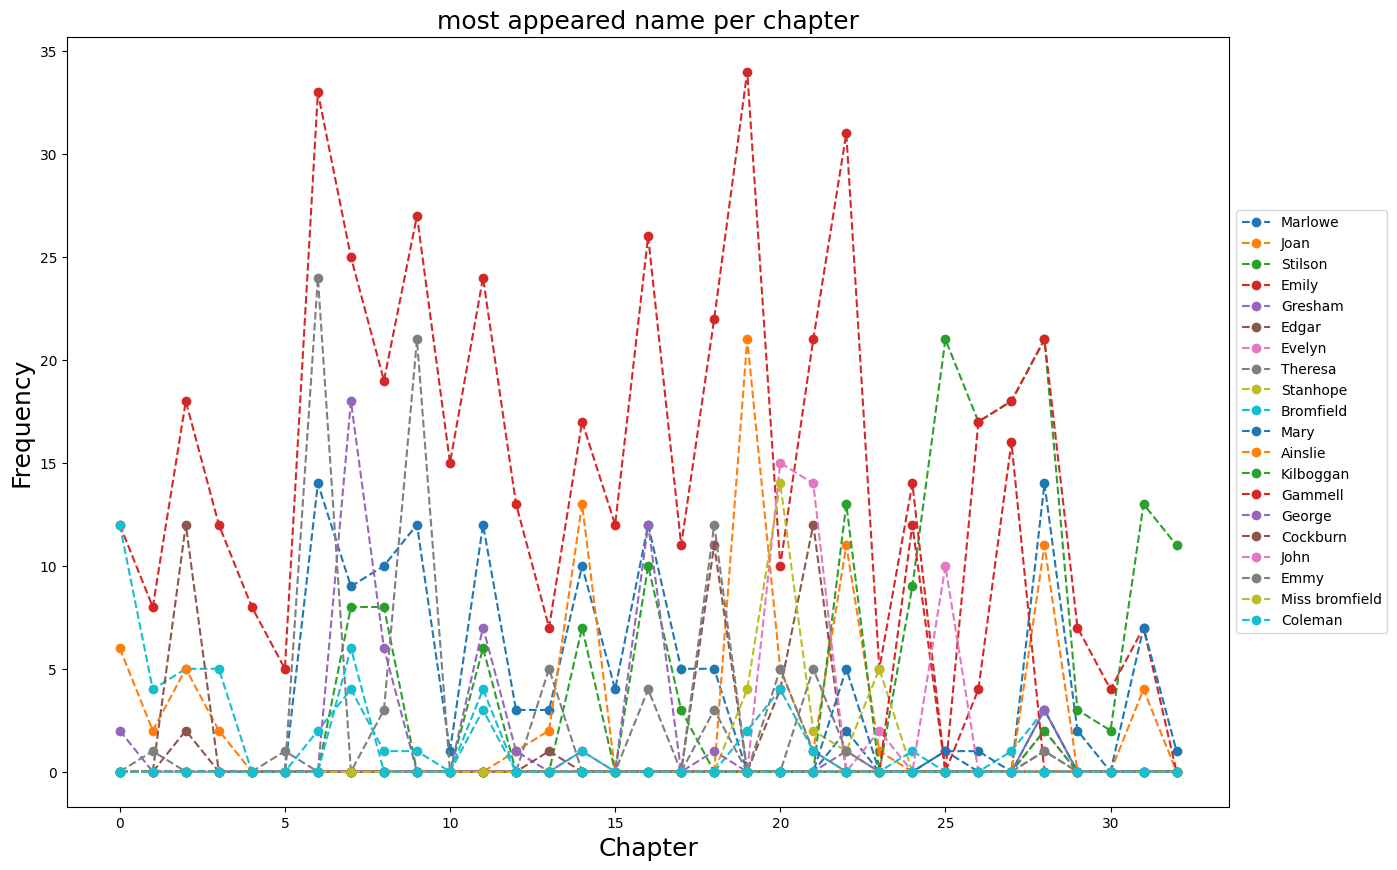

In [33]:
characters_occurence = {}
for name in most_occured_names_list:
    characters_occurence[name] = []
for i in   chapter:
    for name in characters_occurence:
        occurence = i.count(name)
        characters_occurence[name].append(occurence)   
#plot
def plot(characters_occurence_df, title):
    plt.figure(figsize=(15,10))
    for x in characters_occurence_df.columns:
        plt.plot(characters_occurence_df.index, characters_occurence_df[x], '--o', label = x)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title, fontsize=18)
    plt.xlabel('Chapter', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    
characters_occurence_df = pd.DataFrame.from_dict(characters_occurence)

plot(characters_occurence_df, 'most appeared name per chapter')

In [34]:
# total no of pages of the novel
pages = []
for x in chapter:
    split=wrap(x, 1800) # Using the standard of 1800 characters/page
    pages.extend(split)
len(pages)

259

Text(0.5, 0, 'page')

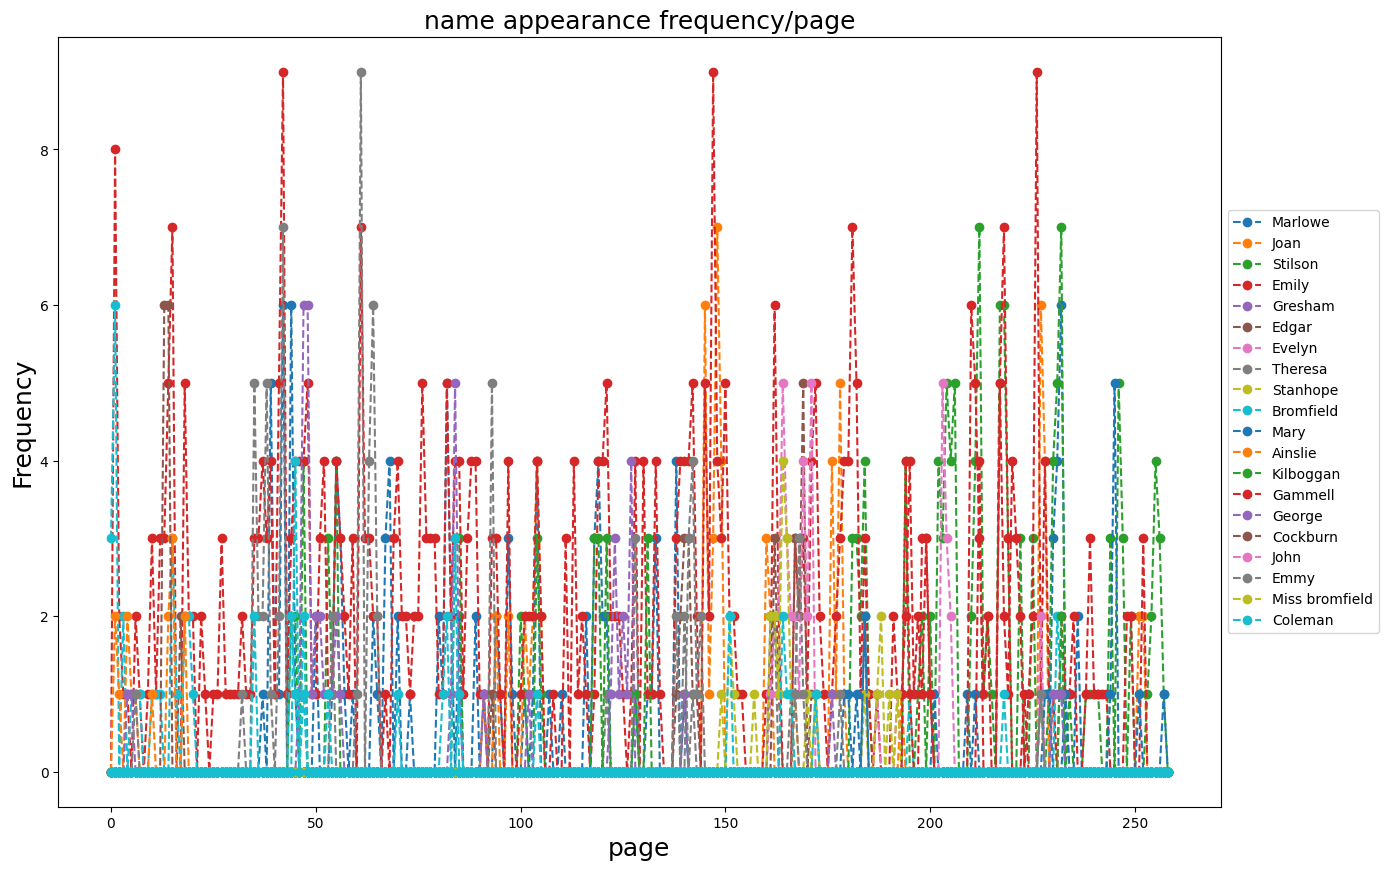

In [35]:
page_occurence= {}
for name in most_occured_names_list:
    page_occurence[name] = []
for page in pages:
    for name in page_occurence:
        num = page.count(name)
        page_occurence[name].append(num)
page_occurence_df = pd.DataFrame.from_dict(page_occurence)
plot(page_occurence_df, 'name appearance frequency/page')
plt.xlabel('page', fontsize=18)



In [36]:
list_text = []
list_categories= []
list_pos = []
for token in Doc:
    list_text.append(token.text)
    list_categories.append(token.lemma_)
    list_pos.append(token.pos_)
words_df =  pd.DataFrame({'text': list_text, 'categories': list_categories, 'pos': list_pos})
words_df.nunique()


text          7944
categories    6044
pos             17
dtype: int64

### SENTIMENT ANALYSIS 

In [37]:
# sentiment analysis of every page
PAGE =  [TextBlob(page).sentiment.polarity for page in pages]
PAGE_average = np.mean(PAGE)
PAGE_df = pd.DataFrame({'text' : pages, 'polarity' : PAGE, 'mean' : PAGE_average})
PAGE_df

,text,polarity,mean
0,I. THE SHIPWRECK. WENTWORTH Bromfield was ...,-0.040476,0.081411
1,"important, as it represented a margin above co...",0.211389,0.081411
2,hope you will never regret it. A girl without ...,0.151389,0.081411
3,"have been ruined many times, will be ruined ma...",0.178721,0.081411
4,"to the neglect of servants, and afterward to t...",0.066406,0.081411
...,...,...,...
254,"embroidery, the latest Paris devisings, crumpl...",0.038715,0.081411
255,glance that here was a man who knew his trade-...,0.080921,0.081411
256,"helplessly round, and there was something in h...",0.035294,0.081411
257,"were going to sleep and nobody, nothing would ...",0.078840,0.081411


Text(0, 0.5, 'Polarity')

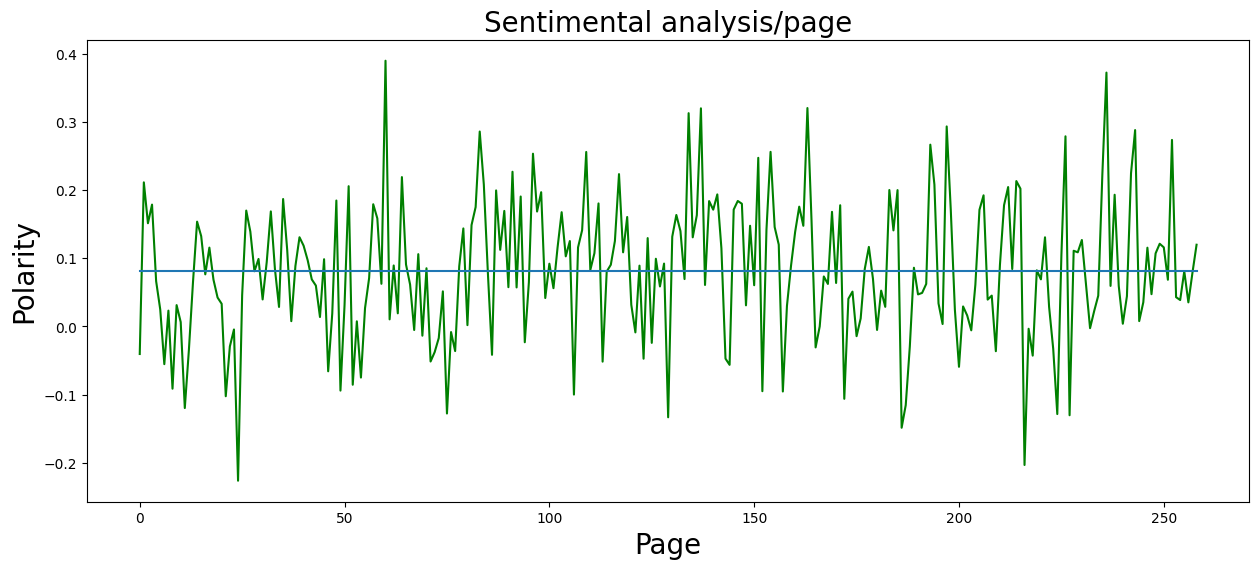

In [38]:
PAGE_df['polarity'].plot(figsize = (15, 6), title = 'Sentimental analysis of every page', 
                                    xlabel = 'Page', ylabel = 'Polarity', color='green')
PAGE_df['mean'].plot()
plt.title('Sentimental analysis/page', fontsize=20)
plt.xlabel('Page', fontsize=20)
plt.ylabel('Polarity', fontsize=20)

Text(0.5, 0, 'Category')

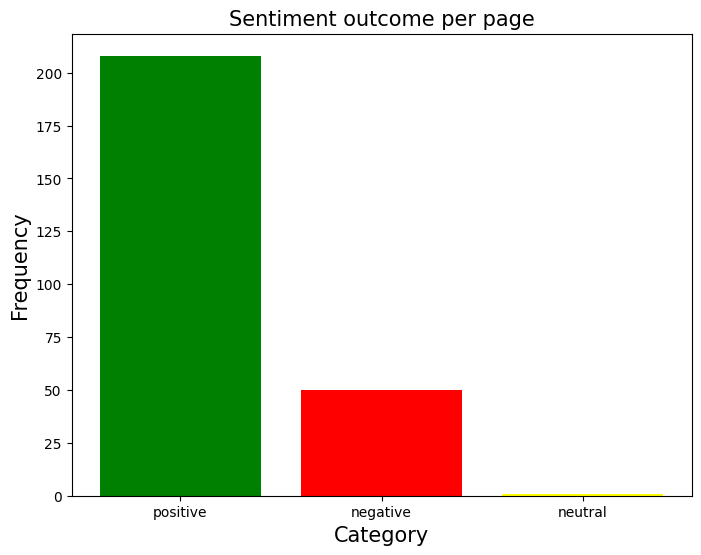

In [39]:
pos= sum(PAGE_df['polarity'] > 0)
neg= sum(PAGE_df['polarity'] < 0)
neu = sum(PAGE_df['polarity'] == 0)

plt.figure(figsize = (8, 6))
plt.bar(['positive', 'negative', 'neutral'], [pos, neg, neu], color = ['green', 'r', 'yellow'])
plt.title('Sentiment outcome per page', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Category', fontsize=15)

### co-occurence graph

In [40]:
import networkx as nx

def names_in_each_page(page_occurence_df):
    page_occurence_df_list = list(page_occurence_df.columns)
    dict_names_by_pages = {}
    for i in page_occurence_df_list.copy():
        dict_names_by_pages[str(i)] = {}
        for j in page_occurence_df_list.copy():
            dict_names_by_pages[str(i)][str(j)] = 0
        page_occurence_df_list.append(i)
    for idx in page_occurence_df.index:
        for i in page_occurence_df.columns:
            if page_occurence_df[i][idx] > 0 :
                for j in page_occurence_df.columns:
                    if page_occurence_df[j][idx] > 0 :
                        dict_names_by_pages[str(i)][str(j)] = dict_names_by_pages[str(i)][str(j)] +1
    return dict_names_by_pages

dict_names_by_pages = names_in_each_page(page_occurence_df)
#dict_names_by_pages

In [41]:
# data frame for cooccurence 
cooccurence = pd.DataFrame(dict_names_by_pages)
cooccurence 

,Marlowe,Joan,Stilson,Emily,Gresham,Edgar,Evelyn,Theresa,Stanhope,Bromfield,Mary,Ainslie,Kilboggan,Gammell,George,Cockburn,John,Emmy,Miss bromfield,Coleman
Marlowe,53,7,11,46,7,2,0,10,1,9,2,0,6,0,4,0,0,1,0,1
Joan,7,26,5,25,3,1,3,3,2,1,3,0,0,0,1,0,0,3,0,0
Stilson,11,5,56,41,6,0,1,2,1,9,6,0,1,7,3,0,3,1,0,3
Emily,46,25,41,193,17,14,11,23,11,26,8,8,6,9,9,2,0,9,0,3
Gresham,7,3,6,17,17,0,0,1,0,3,0,0,0,0,0,0,0,0,0,2
Edgar,2,1,0,14,0,15,6,7,3,1,0,0,0,0,1,0,0,5,0,0
Evelyn,0,3,1,11,0,6,14,5,9,3,0,0,0,0,0,0,0,4,0,0
Theresa,10,3,2,23,1,7,5,26,3,2,0,0,2,0,0,0,0,3,0,0
Stanhope,1,2,1,11,0,3,9,3,17,5,1,0,0,0,0,0,0,0,0,0
Bromfield,9,1,9,26,3,1,3,2,5,33,0,6,1,2,3,0,0,1,0,2


In [42]:
#add weights to edges
edge_list = [] #test networkx
for index, row in cooccurence.iterrows():
    i = 0
    for col in row:
        weight = float(col)/193
        edge_list.append((index, cooccurence.columns[i], weight))
        i += 1

        
names = list(cooccurence.columns)
#names

In [43]:
#create duple of char, occurance in novel

updated_edge_list = [x for x in edge_list if not x[2] == 0.0]
node_list = []
for i in names:
    for e in updated_edge_list:
        if i == e[0] and i == e[1]:
            node_list.append((i, e[2]*6))
for i in node_list:
    if i[1] == 0.0:
        node_list.remove(i)

#remove self references
for i in updated_edge_list:
    if i[0] == i[1]:
        updated_edge_list.remove(i)

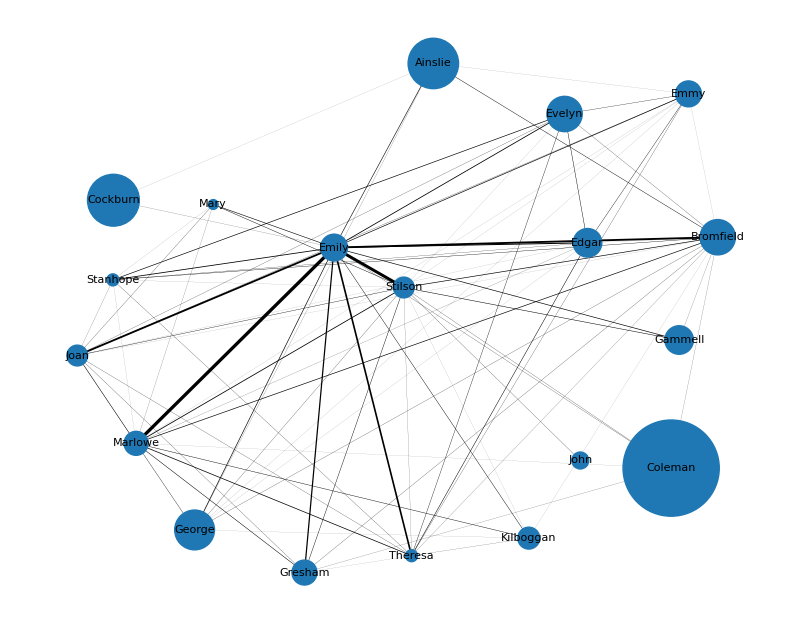

In [44]:
plt.subplots(figsize=(10,8))
#networkx graph time!
G = nx.Graph()
for i in sorted(node_list):
    G.add_node(i[0], size = i[1])
G.add_weighted_edges_from(updated_edge_list)

updated_node_order = []
for i in names:
    for x in node_list:
        if x[0] == i:
            updated_node_order.append(x)
            
#reorder edge list - this was a pain
test = nx.get_edge_attributes(G, 'weight')
updated_again_edges = []
for i in nx.edges(G):
    for x in test:
        if i[0] == x[0] and i[1] == x[1]:
            updated_again_edges.append(test[x])
            
            
#drawing custimization
node_scalar = 800
edge_scalar = 10
sizes = [x[1]*node_scalar for x in updated_node_order]
widths = [x*edge_scalar for x in updated_again_edges]

#draw the graph
pos = nx.spring_layout(G, k=0.42, iterations=15)

nx.draw(G, pos, with_labels=True, font_size = 8, font_weight =None,
        node_size = sizes, width = widths)